### Setup packages
First we will suppress all the info messages for clearer output and import right packages; TensorFlow and Keras

In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Suppress info messages for clearer output


import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import numpy as np

# Import NNs and some aditional keras functions for the testing of different models
from typing import cast, Any
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, AvgPool2D, Dropout
from keras.optimizers import SGD, AdamW
from keras.initializers import HeNormal, GlorotNormal, RandomNormal, RandomUniform

E0000 00:00:1760992772.225215 2874020 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760992772.228146 2874020 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760992772.234752 2874020 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760992772.234760 2874020 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760992772.234761 2874020 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760992772.234762 2874020 computation_placer.cc:177] computation placer already registered. Please check linka

### Load in the MNIST-fashion dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

#Create training set and validation set
X_valid, X_train = X_train_full[:6000]/255.0, X_train_full[6000:]/255.0 #Confert 8-bit int to floating point in [0,1]
y_valid, y_train = y_train_full[:6000], y_train_full[6000:] 

#Class names corresponding to label, which is represented with integer
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(300, 'relu'))
model.add(keras.layers.Dense(100, 'relu'))
model.add(keras.layers.Dense(10, 'softmax'))

model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Optimize Hyperparameters (HP)

Previous cells were used to learn how to setup a basic vanilla NN and a CNN. Our next task is to test different HP. Things that will be tested are initialization techniques, activation functions, optimizers and regularization. The goal is not to find the best accuracy but more learn what the effect is of some hyperparameters on these networks. 

### Vanilla NN class

In [16]:
class vanillaNN():
    """Vanilla Neural Network class using Keras and Tensorflow for simpler implementation of HPO"""

    def __init__(self, initialization=GlorotNormal(), activation='relu', optimizer:str|object='adamW', 
                 regularization='l1', dropout=0.5):
        self.initialization = initialization
        self.activation = activation
        self.optimizer = optimizer
        self.regularization = regularization
        self.dropout = dropout

        self.model = keras.Sequential([
            keras.Input(shape=(28, 28)),
            Flatten(),
            self._make_layer(300),
            Dropout(self.dropout),
            self._make_layer(100),
            Dropout(self.dropout),
            Dense(10, 'softmax')
        ])

        self.model.compile(optimizer=cast(Any, self.optimizer), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def _make_layer(self, num_neurons):
        # Cast initializer to Any to satisfy static type checkers
        layer = Dense(num_neurons, activation=self.activation, kernel_initializer=cast(Any, self.initialization))
        return layer

    def fit_model(self, X, y, epochs=30, validation_data=None):
        history = self.model.fit(X, y, epochs=epochs, validation_data=validation_data, verbose=1)
        return history
    
    def _summary(self):
        print(self.model.summary())

    


### CNN class

In [2]:
class CNN():
    """Convolutional Neural Network class using Keras and Tensorflow for optimizing Hyperparameters"""
    
    def __init__(self, initialization=GlorotNormal(), activation='relu', optimizer:str|object='adamW', 
                 regularization='l1', dropout=0.5, input_shape=(28, 28, 1)):
        self.initialization = initialization
        self.activation = activation
        self.optimizer = optimizer
        self.regularization = regularization
        self.dropout = dropout
        self.input_shape = input_shape

        self.model = keras.models.Sequential([
            keras.Input(shape=input_shape),
            Conv2D(64, 5, activation=self.activation, padding='same'),
            MaxPool2D(2),
            self._make_layer(128, 3),
            self._make_layer(128, 3),
            MaxPool2D(2), 
            self._make_layer(256, 3),
            self._make_layer(256, 3),
            AvgPool2D(2),
            Flatten(),
            Dense(128, activation=self.activation),
            Dropout(self.dropout),
            Dense(64, activation=self.activation),
            Dropout(self.dropout),
            Dense(10, activation='softmax')
        ])

        self.model.compile(optimizer=cast(Any, self.optimizer), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def _make_layer(self, num_neurons, kernel_size):
        layer = Conv2D(num_neurons, kernel_size=kernel_size, activation=self.activation, kernel_initializer=cast(Any, self.initialization), padding='same')
        return layer

    def fit_model(self, X, y, epochs=30, validation_data=None):
        return self.model.fit(X, y, epochs=epochs, validation_data=validation_data, verbose=1)
    
    def _summary(self):
        print(self.model.summary())

### Run vanilla NN for different HP configurations

In [ ]:
activation_funcs = ['relu', 'tanh', 'sigmoid'] 
initializers = {HeNormal(): 'HeNormal', RandomNormal(): 'RandomNormal', GlorotNormal(): 'GlorotNormal'}
regularizations = [None, 'l1', 'l2']
dropouts = [0, 0.3, 0.5]
learning_rates = [0.005, 0.01, 0.015, 0.02]

len_loops = len(activation_funcs) * len(initializers) * len(regularizations) * len(dropouts) * len(learning_rates)
i = 0
final = pd.DataFrame([], columns=['optimizer', 'initializer', 'regularization', 'activation_function', 'best_valid_acc', 'last_valid_acc', 'last_train_acc', 'model'])
for lr in learning_rates:
    for initial in initializers.keys():
        for regular in regularizations:
            for active in activation_funcs:
                for drops in dropouts:
                        if (i % 10) == 0:
                            print(f"{i}/{len_loops}")
                        i+=1
                        optimiz = AdamW(learning_rate=lr/10)
                        model = vanillaNN(initialization=initial, activation=active, optimizer=optimiz, regularization=regular, dropout=drops)
                        hist = model.fit_model(X_train, y_train, epochs=35, validation_data=(X_valid, y_valid))
                        max_val = max(hist.history['val_accuracy'])
                        last_val = hist.history['val_accuracy'][-1]
                        last_train = hist.history['accuracy'][-1]

                        setup_dict = pd.DataFrame([{'optimizer': 'AdamW', 
                            'initializer': initializers[initial],
                            'regularization': regular,
                            'activation_function': active,
                            'dropout': str(drops),
                            'lr': str(lr),
                            'best_valid_acc': max_val,
                            'last_valid_acc': last_val,
                            'last_train_acc': last_train,
                            'model': 'vanilla_NN'}])
                
                        final = pd.concat((final, setup_dict), ignore_index=True)

final.to_csv('Configuration_performance_file.csv')

### Statistical Test to see which parameters and first order combinations of pairs are the most importartent

In our previous training of the model excecuted a full factorial design. Now we would like to test which variables have the greatest effect on the performance. For the main effects we will take the $ S(x_{i}) = \frac{var(x_{i})}{var{\bold{X}}}$, with $x_{i} \subset \bold{X} $. In words this describes is describes how much of the total variance on variable explains of the total variance. 


In [7]:
df = pd.read_csv('Configuration_performance_file.csv', index_col=0)
columns = ['initializer', 'regularization', 'activation_function', 'dropout']
var_X = df['best_valid_acc'].var()
var_x = {}
for param in columns:
    df_copy = df.copy()
    var_x[param] = float(np.var(df.groupby(param)['best_valid_acc'].mean()) / var_X) # type: ignore

#Forgot to add the learning rate to the csv but we can still derive its variance
var_x['lr'] = float(np.var(df.groupby(columns)['best_valid_acc'].mean()) / var_X) # type: ignore
print('vanilla NN: ', var_x)

df = pd.read_csv('Configuration_performance_file_cnn.csv', index_col=0)
columns = ['initializer', 'regularization', 'activation_function', 'dropout', 'optimizer']
var_X = df['best_valid_acc'].var()
var_x = {}
for param in columns:
    df_copy = df.copy()
    var_x[param] = float(np.var(df.groupby(param)['best_valid_acc'].mean().to_numpy()) / var_X) # type: ignore

print('CNN: ', var_x)


vanilla NN:  {'initializer': 0.0002443159386344149, 'regularization': 9.840915296498053e-05, 'activation_function': 0.42564803440853044, 'dropout': 0.2025321178295453, 'lr': 0.6688080810501781}
CNN:  {'initializer': 0.0030408075982708256, 'regularization': 0.00010831147732210297, 'activation_function': 0.23724047201920068, 'dropout': 0.013452382087283693, 'optimizer': 0.3400032902768165}


It is clear form this that the initializer and regularization barely had any effect on the performance of the vanill NN. For the regularization this is to be expected as our models are not that deep and the effect of exploding gradients does not really occur yet (Look for reference). For the initializers it is not yet clear why this has no effect. The full effect probably only occurs when the network is larger aswell but there is not yet a derivation or source found that supports this.

However, for the next part we will also the CNN on the most important hyperparameters (HP). These params or activation funcitons, dropouts and learning rates. We assumed that the importance of the HPs would also count for the CNN and not only the vanilla NN and this leads us to think that we only need to train the CNN varying those HPs. This is also done to reduce computation time as running the CNN on all different Hyperparameter configurations (HPC) as those for the vanilla NN would approx take 50 hours which seems a bit extreme. 

In [ ]:
activation_funcs = ['relu', 'tanh', 'sigmoid'] 
dropouts = [0, 0.3, 0.5]
learning_rates = [0.005, 0.01, 0.015, 0.02]

len_loops = len(activation_funcs) * len(dropouts) * len(learning_rates)
i = 0

final = pd.DataFrame([], columns=['optimizer', 'initializer', 'regularization', 'activation_function', 'best_valid_acc', 'last_valid_acc', 'last_train_acc', 'model'])
for lr in learning_rates:
    for active in activation_funcs:
        for drops in dropouts:
            if (i % 10) == 0:
                print(f"{i}/{len_loops}")
            i += 1
            optimiz = AdamW(learning_rate=lr/10)
            model = CNN(initialization=RandomNormal(), activation=active, optimizer=optimiz, regularization=None, dropout=drops)
            hist = model.fit_model(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))
            max_val = max(hist.history['val_accuracy'])
            last_val = hist.history['val_accuracy'][-1]
            last_train = hist.history['accuracy'][-1]

            setup_dict = pd.DataFrame([{'optimizer': 'AdamW', 
                'initializer': 'RandomNormal',
                'regularization': None,
                'activation_function': active,
                'dropout': str(drops),
                'best_valid_acc': max_val,
                'last_valid_acc': last_val,
                'last_train_acc': last_train,
                'model': 'CNN'}])
                
            final = pd.concat((final, setup_dict), ignore_index=True)

final.to_csv('Configuration_performance_file_cnn_1.csv')

### Best configurations

We will first make a boxplot of the CNN performances vs the Vanilla NN to see what works best. Afte that we will take the top-3 configurations to also train on the CIFAR-10 dataset. But before we train those networks on the CIFAR-10, we'll also test the performances on the test set to see if they actually generalized well. 

Enough talking, lets get into it. 

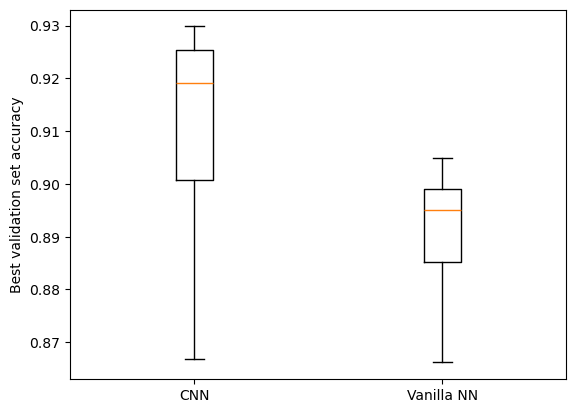

In [3]:
cnn_df = pd.read_csv('Configuration_performance_file_cnn_1.csv').iloc[:,1:]
vanilla_df = pd.read_csv('Configuration_performance_file.csv').iloc[:,1:]

fig, ax = plt.subplots(1, 1)
ax.boxplot([cnn_df[cnn_df['best_valid_acc'] > 0.86]['best_valid_acc'], vanilla_df[vanilla_df['best_valid_acc'] > 0.86]['best_valid_acc']])
ax.set_ylabel('Best validation set accuracy')
ax.set_xticklabels(['CNN', 'Vanilla NN'])
plt.show()

When trimming away the worst performing configurations for both type of networks we can see that the CNN networks outperform the vanill NN, which is to be expected. 

In [18]:

cnn_df['model'] = 'CNN'
cnn_df['lr'] = [0.005/10] * 9 + [0.01/10] * 9 + [0.015/10] * 9 + [0.02/10] * 9
vanilla_df['model'] = 'vanilla NN'
total_df = pd.concat([cnn_df, vanilla_df])

best_configs = total_df.nlargest(3, 'best_valid_acc')
print(best_configs)

##### Calculate the performance on the tesst set to really determine the performance of all the configurations to see which are the best ######

test_performances = []

for i in range(3):
    config = best_configs.iloc[i]
    optim = AdamW(learning_rate=config['lr'])
    model = CNN(initialization=RandomNormal(), activation=config['activation_function'], optimizer=optim, regularization=None, dropout=config['dropout'])
    hist = model.fit_model(X_train, y_train, epochs=15, validation_data=[X_test, y_test])
    test_performances.append(max(hist.history['val_accuracy']))

print(test_performances)



   optimizer   initializer regularization activation_function  best_valid_acc  \
2      AdamW  RandomNormal            NaN                relu        0.929833   
1      AdamW  RandomNormal            NaN                relu        0.929500   
10     AdamW  RandomNormal            NaN                relu        0.929333   

    last_valid_acc  last_train_acc model  dropout      lr  
2         0.927500        0.968222   CNN      0.5  0.0005  
1         0.926333        0.977167   CNN      0.3  0.0005  
10        0.929333        0.968518   CNN      0.3  0.0010  
Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.7037 - loss: 0.8196 - val_accuracy: 0.8518 - val_loss: 26.6126
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.8533 - loss: 0.4351 - val_accuracy: 0.8701 - val_loss: 23.3311
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.8846 - loss: 0.3480 - val_accuracy: 0.8649 - val_loss: 18.5874
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━

### Results

All top-3 are CNN with a relu activation funciton and a dropout and a relatively low learning rate.

The best accuracy of the top-3 configurations is 0.89450, 0.89990, 0.89420, which is around 3% lower than on the validation set. This is quite good we suppose


In [4]:
cifar_10 = keras.datasets.cifar10 
(X_train_full, y_train_full), (X_test, y_test) = cifar_10.load_data() #Load in CIFAR-10 dataset

X_train, X_test = X_train_full/255.0, X_test/255.0 #Confert 8-bit int to floating point in [0,1]

cnn_df['lr'] = [0.005/10] * 9 + [0.01/10] * 9 + [0.015/10] * 9 + [0.02/10] * 9
total_df = pd.concat([cnn_df, vanilla_df])

best_configs = total_df.nlargest(3, 'best_valid_acc')
test_performances = []
for i in range(3):
    config = best_configs.iloc[i]
    optim = AdamW(learning_rate=config['lr'])
    model = CNN(initialization=RandomNormal(), activation=config['activation_function'], optimizer=optim, regularization=None, dropout=config['dropout'], input_shape=(32, 32, 3))
    hist = model.fit_model(X_train, y_train_full, epochs=25, validation_data=(X_test, y_test))
    test_performances.append(max(hist.history['val_accuracy']))

print(test_performances)



Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.2587 - loss: 1.9524 - val_accuracy: 0.3822 - val_loss: 1.6667
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.4330 - loss: 1.5433 - val_accuracy: 0.5284 - val_loss: 1.3019
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.5397 - loss: 1.3009 - val_accuracy: 0.6274 - val_loss: 1.0625
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.6184 - loss: 1.1062 - val_accuracy: 0.6802 - val_loss: 0.9426
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.6762 - loss: 0.9621 - val_accuracy: 0.6884 - val_loss: 0.9060
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.7200 - loss: 0.8431 - val_accuracy: 0.7322 - val_loss: 0.8119
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7494 - loss: 0.7539 - val_accuracy: 0.7328 - val_loss: 0.8078
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7802 -

### Results

It is difficult to say it translates directly as it does converge slower. However, it can be possible that using more epochs can improve the results